![image.png](https://i.imgur.com/a3uAqnb.png)

# **🐾 Pet Segmentation with U-Net**
In this lab, we will:  
✅ Use the **Oxford-IIIT Pet Dataset** for segmentation  
✅ Build a **custom U-Net model with residual connections**  
✅ Train and evaluate the U-Net model  

## **1️⃣ Dataset Class**

The Oxford-IIIT Pet dataset is preloaded using PyTorch's `OxfordIIITPet` API. We preprocess:
1. **Images**: Normalize and resize  
2. **Targets**: Convert segmentation masks to tensors  

In [1]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Define transforms for images
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# need to subtract 1 from the make to bring it from 1-3 range to 0-2 range (CrossEntropyLoss requires labels to start from 0)
class SubtractOne(nn.Module):
  def forward(self, img):
    return img-1

# Define transforms for masks
target_transforms = transforms.Compose([                    ## Notice how we have a transform for the target (because it is an image) 
    transforms.Resize((256, 256)),                          ##        and another one for the image itself.  
    transforms.PILToTensor(),                               
    SubtractOne()                                           ## Question: What do you think would happen if we
                                                            ##  added rotation augmentation to the image only?
])


# Load train and test datasets
train_dataset = OxfordIIITPet(
    root='data/train/', split="trainval", target_types="segmentation", download=True,
    transform=img_transforms, target_transform=target_transforms
)

test_dataset = OxfordIIITPet(
    root='data/test/', split="test", target_types="segmentation", download=True,
    transform=img_transforms, target_transform=target_transforms
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train Dataset: {len(train_dataset)} images")
print(f"Test Dataset: {len(test_dataset)} images")

Train Dataset: 3680 images
Test Dataset: 3669 images


### Let's display some images

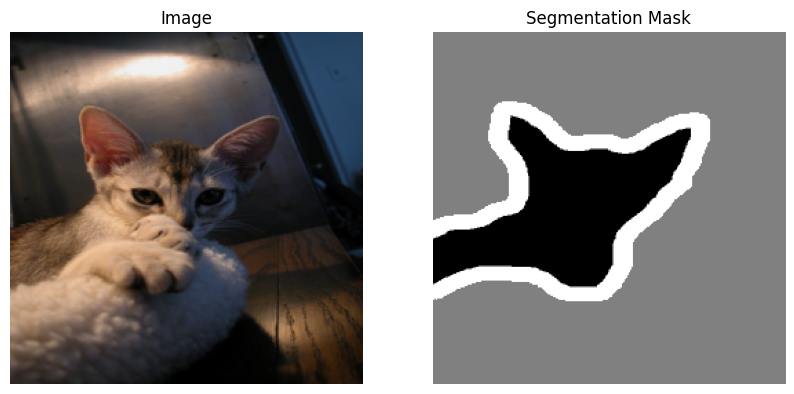

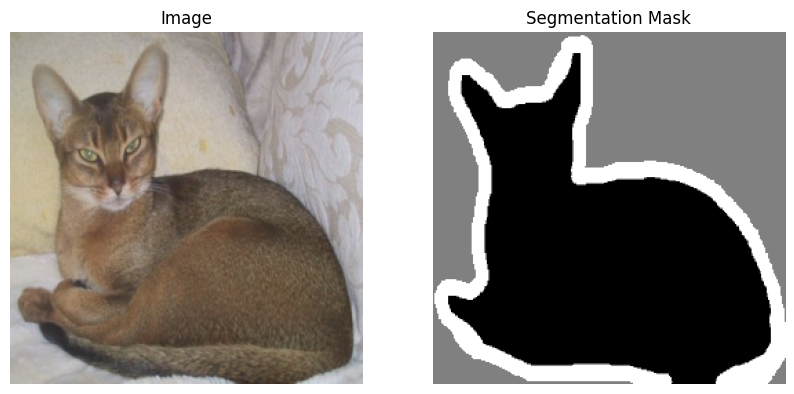

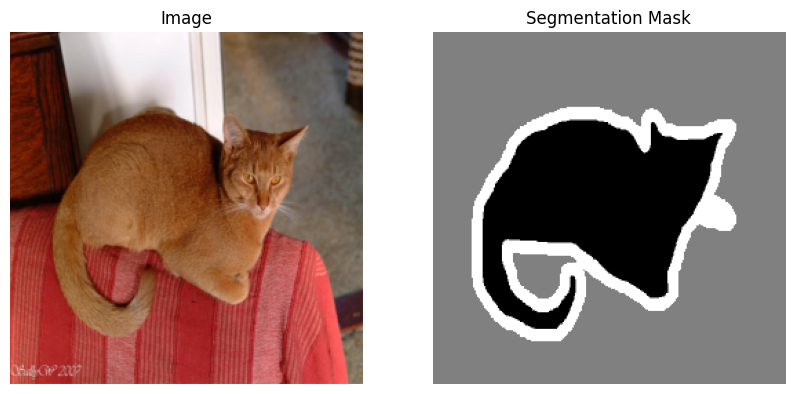

In [2]:
import matplotlib.pyplot as plt

# Display some images with their masks
for i in range(10,13):
    img, mask = train_dataset[i]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    plt.show()


## **2️⃣ Model Class**

#### We define a **U-Net** model with skip connections (residuals) implemented using **concatenation**.


In [3]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    """U-Net model with skip connections (Residuals)."""
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # --- ENCODER ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # --- BOTTLENECK ---
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        # --- DECODER ---
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  # 512 + 512 (residual) = 1024 input channels
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  # 256 + 256 (residual) = 512 input channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # 128 + 128 (residual) = 256 input channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 64 + 64 (residual) = 128 input channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # --- ENCODER ---
        enc1 = self.enc1(x)                  
        enc2 = self.enc2(self.pool(enc1))    
        enc3 = self.enc3(self.pool(enc2))    
        enc4 = self.enc4(self.pool(enc3))    
        
        # --- BOTTLENECK ---
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # --- DECODER + SKIP CONNECTIONS ---
        x = self.up4(bottleneck)
        x = torch.cat([x, enc4], dim=1)
        dec4 = self.dec4(x)
        
        x = self.up3(dec4)
        x = torch.cat([x, enc3], dim=1)
        dec3 = self.dec3(x)
        
        x = self.up2(dec3)
        x = torch.cat([x, enc2], dim=1)
        dec2 = self.dec2(x)
        
        x = self.up1(dec2)
        x = torch.cat([x, enc1], dim=1)
        dec1 = self.dec1(x)
        
        # --- FINAL LAYER ---
        return self.final(dec1)


## **3️⃣ Training and Validation Loops**

To train the U-Net model, we use **Binary Cross Entropy (BCE) Loss**.


In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device).squeeze(dim=1).to(torch.long)  # mask shape becomes [N, H, W]
        
        outputs = model(images)  
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).squeeze(dim=1).to(torch.long)    # mask shape becomes [N, H, W]

            outputs = model(images)  # Now [N, H, W]
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

## **4️⃣ Running Training**

In [5]:
import torch

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=3).to(device)  # Output channels = 3 classes 

## **🔹 Why `out_channels=3` in U-Net?**
Our segmentation model needs to **predict probabilities** for each pixel belonging to **one of 3 classes** (background, pet, and boundary).  

✅ Instead of predicting a **single-channel mask**, we predict **3 channels**, where:  
- **Channel 0** → Probability of **background**  
- **Channel 1** → Probability of **pet**  
- **Channel 2** → Probability of **boundary**  

🚀 **How does it work?**
- The output of U-Net is a **(batch_size, 3, height, width)** tensor.
- We use `CrossEntropyLoss`, which expects a **multi-class probability map**.
- The **target masks** should be in **label-encoded format** (`(batch_size, height, width)` with values `0, 1, 2` for each pixel).
- In inference, we could take `argmax(dim=1)`, which picks the class with the highest probability for each pixel.



In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 10  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 920/920 [07:11<00:00,  2.13it/s]


Epoch 1/10: Train Loss = 0.6157, Val Loss = 0.4638


100%|██████████| 920/920 [07:02<00:00,  2.18it/s]


Epoch 2/10: Train Loss = 0.4435, Val Loss = 0.5036


100%|██████████| 920/920 [07:02<00:00,  2.18it/s]


Epoch 3/10: Train Loss = 0.3911, Val Loss = 0.3840


100%|██████████| 920/920 [07:01<00:00,  2.18it/s]


Epoch 4/10: Train Loss = 0.3614, Val Loss = 0.3446


100%|██████████| 920/920 [07:01<00:00,  2.18it/s]


Epoch 5/10: Train Loss = 0.3336, Val Loss = 0.3358


100%|██████████| 920/920 [07:02<00:00,  2.18it/s]


Epoch 6/10: Train Loss = 0.3164, Val Loss = 0.3150


100%|██████████| 920/920 [07:02<00:00,  2.18it/s]


Epoch 7/10: Train Loss = 0.3001, Val Loss = 0.3152


100%|██████████| 920/920 [07:01<00:00,  2.18it/s]


Epoch 8/10: Train Loss = 0.2841, Val Loss = 0.3014


100%|██████████| 920/920 [07:02<00:00,  2.18it/s]


Epoch 9/10: Train Loss = 0.2679, Val Loss = 0.2882


100%|██████████| 920/920 [07:01<00:00,  2.18it/s]


Epoch 10/10: Train Loss = 0.2574, Val Loss = 0.2974


### Plot loss

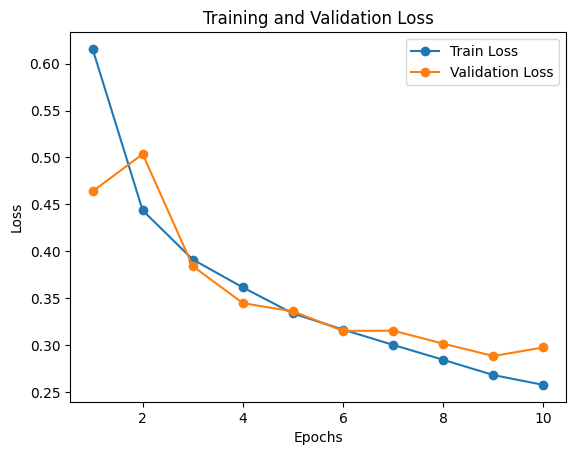

In [7]:
### **🔹 Plot Training Loss Curve**
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## **5️⃣ Visualizing Predictions**

To evaluate the model, we compare the predicted segmentation masks with the ground truth masks.


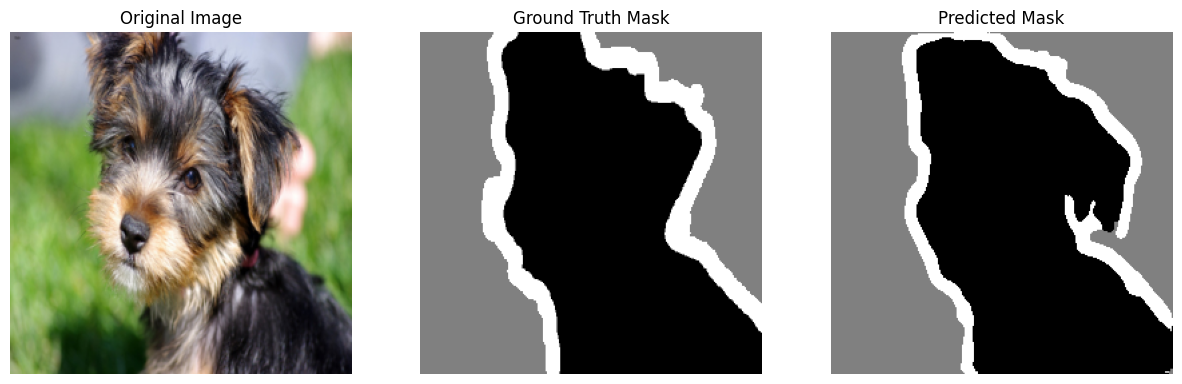

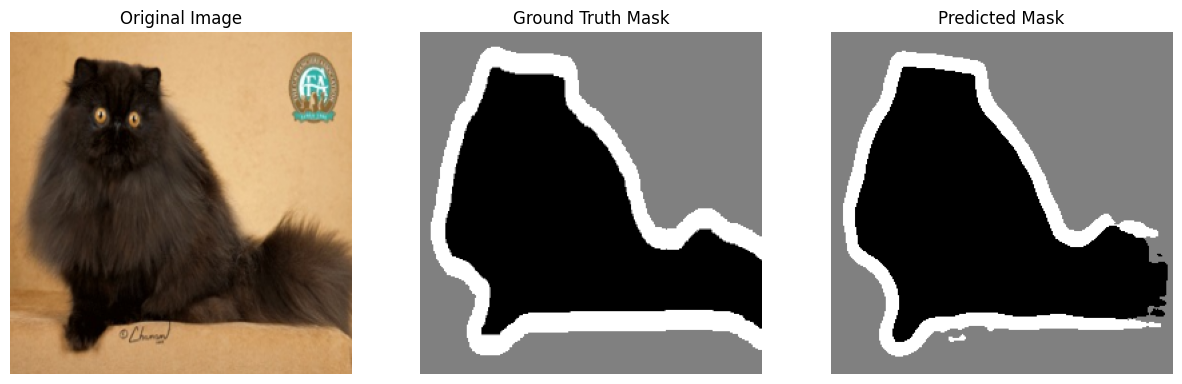

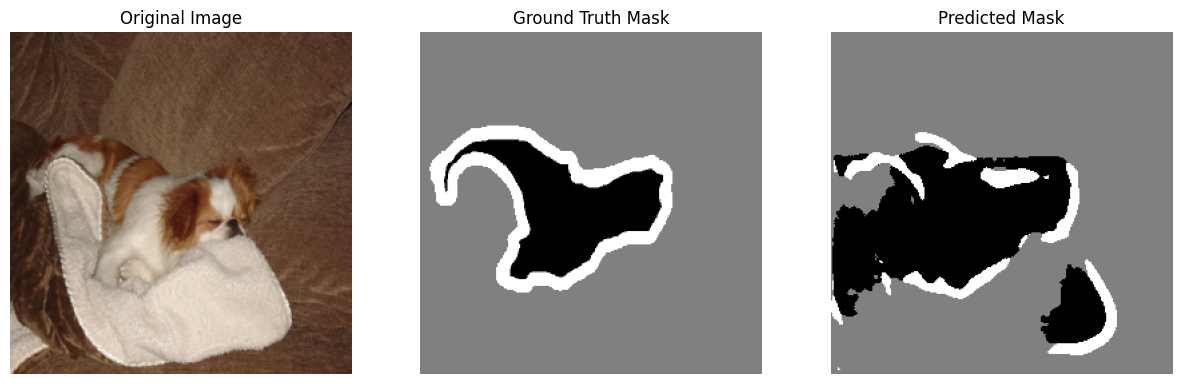

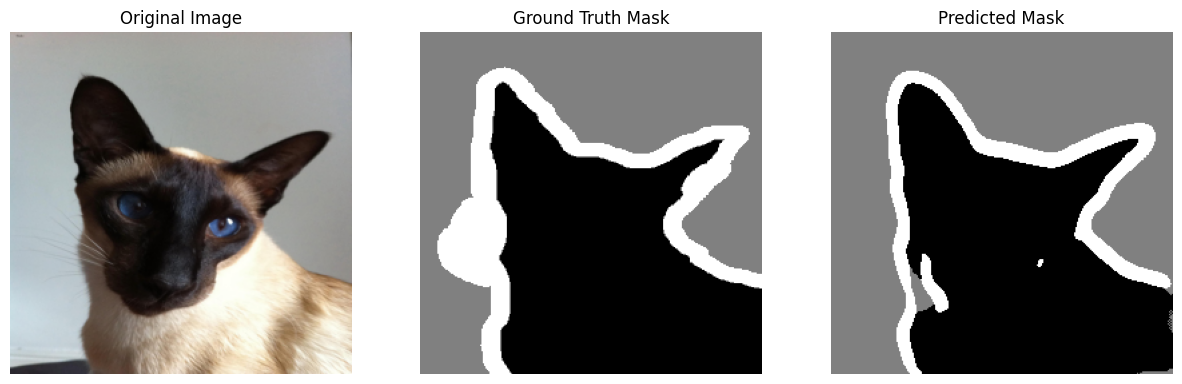

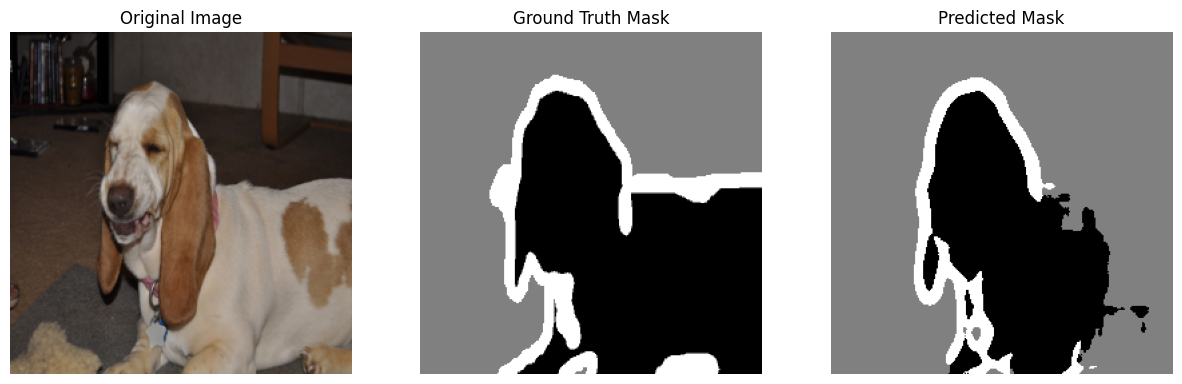

In [8]:
import random
import matplotlib.pyplot as plt

model.eval()
# Get some test samples
test_samples = random.sample(range(len(test_dataset)), 5)

for idx in test_samples:
    img, mask = test_dataset[idx]

    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0).to(device))  # Forward pass

    pred_mask = torch.softmax(pred_mask, dim=1)  # Convert logits to probabilities
    pred_mask = pred_mask.argmax(dim=1).cpu().squeeze().numpy()  # Get class with highest probability

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.permute(1, 2, 0))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_mask, cmap="gray")  # Show class map
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()


### Contributed by: Mohamed Eltayeb